# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры.  Нужно довести метрику до 0.59. 

Дополнительно необходимл измерять *AUC-ROC* и сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Описание данных:
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата


Целевой признак:
- `Exited` — факт ухода клиента

### План работы:

1. [Загрузка данных, импорт библиотек](#start)
2. [Изучение и предобработка признаков](#eda)
3. [Подготовка данных для двух моделей](#model_selection)
4. [Исследование моделей без учета дисбаланса классов](#dis)
5. [Борьба с дисбалансом](#balanced)
6. [Тестирование модели](#testing)
7. [Общий вывод](#out)

---
<a id='start'></a>
## 1. Загрузка данных

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18,6)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Перед нами датасет с данными о клиентах банка, 14 столбцов, данные из `RowNumber`, `CustomerId` и `Surname` не понадобятся для построения моделей, в столбце `Tenure` присутствуют пропуски. Приведем названия столбцов к нижнему регистру:

In [5]:
df.columns = df.columns.str.lower()

### Вывод

На этом этапе импортировали библиотеки, загрузили данные, привели названия столбцов к нижнему регистру, получили сводную информацию о датасете: 10000 записей, 14 столбцов с данными, из них 10 - признаки и `Exited` целевая переменная. В столбце `Tenure` присутсвуют пропуски. Продолжим исследовать датасет.

---
<a id='eda'></a>
## 2. Изучение и предобработка признаков

Изучим описательные статистики для столбцов с количественными данными:

In [6]:
inf = (df.select_dtypes(include=['int64','float64']).describe().round(1)
       .applymap(lambda x: '{}'.format(int(x)) if x.is_integer() else '{:.1f}'.format(x))
       .drop(['customerid', 'rownumber'], axis=1))
display(inf)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000,10000,9091,10000,10000,10000,10000,10000,10000
mean,650.5,38.9,5,76485.9,1.5,0.7,0.5,100090.2,0.2
std,96.7,10.5,2.9,62397.4,0.6,0.5,0.5,57510.5,0.4
min,350,18,0,0,1,0,0,11.6,0
25%,584,32,2,0,1,0,0,51002.1,0
50%,652,37,5,97198.5,1,1,1,100193.9,0
75%,718,44,7,127644.2,2,1,1,149388.2,0
max,850,92,10,250898.1,4,1,1,199992.5,1


Можно отметить большую разницу в масштабах данных в разных столбцах. В столбце с целевым признаком `Exited` 20% записей с классом 1, что говорит о дисбалансе. Изучим распределения и выбросы у количественных признаков, при необходимости выполним предобработку:

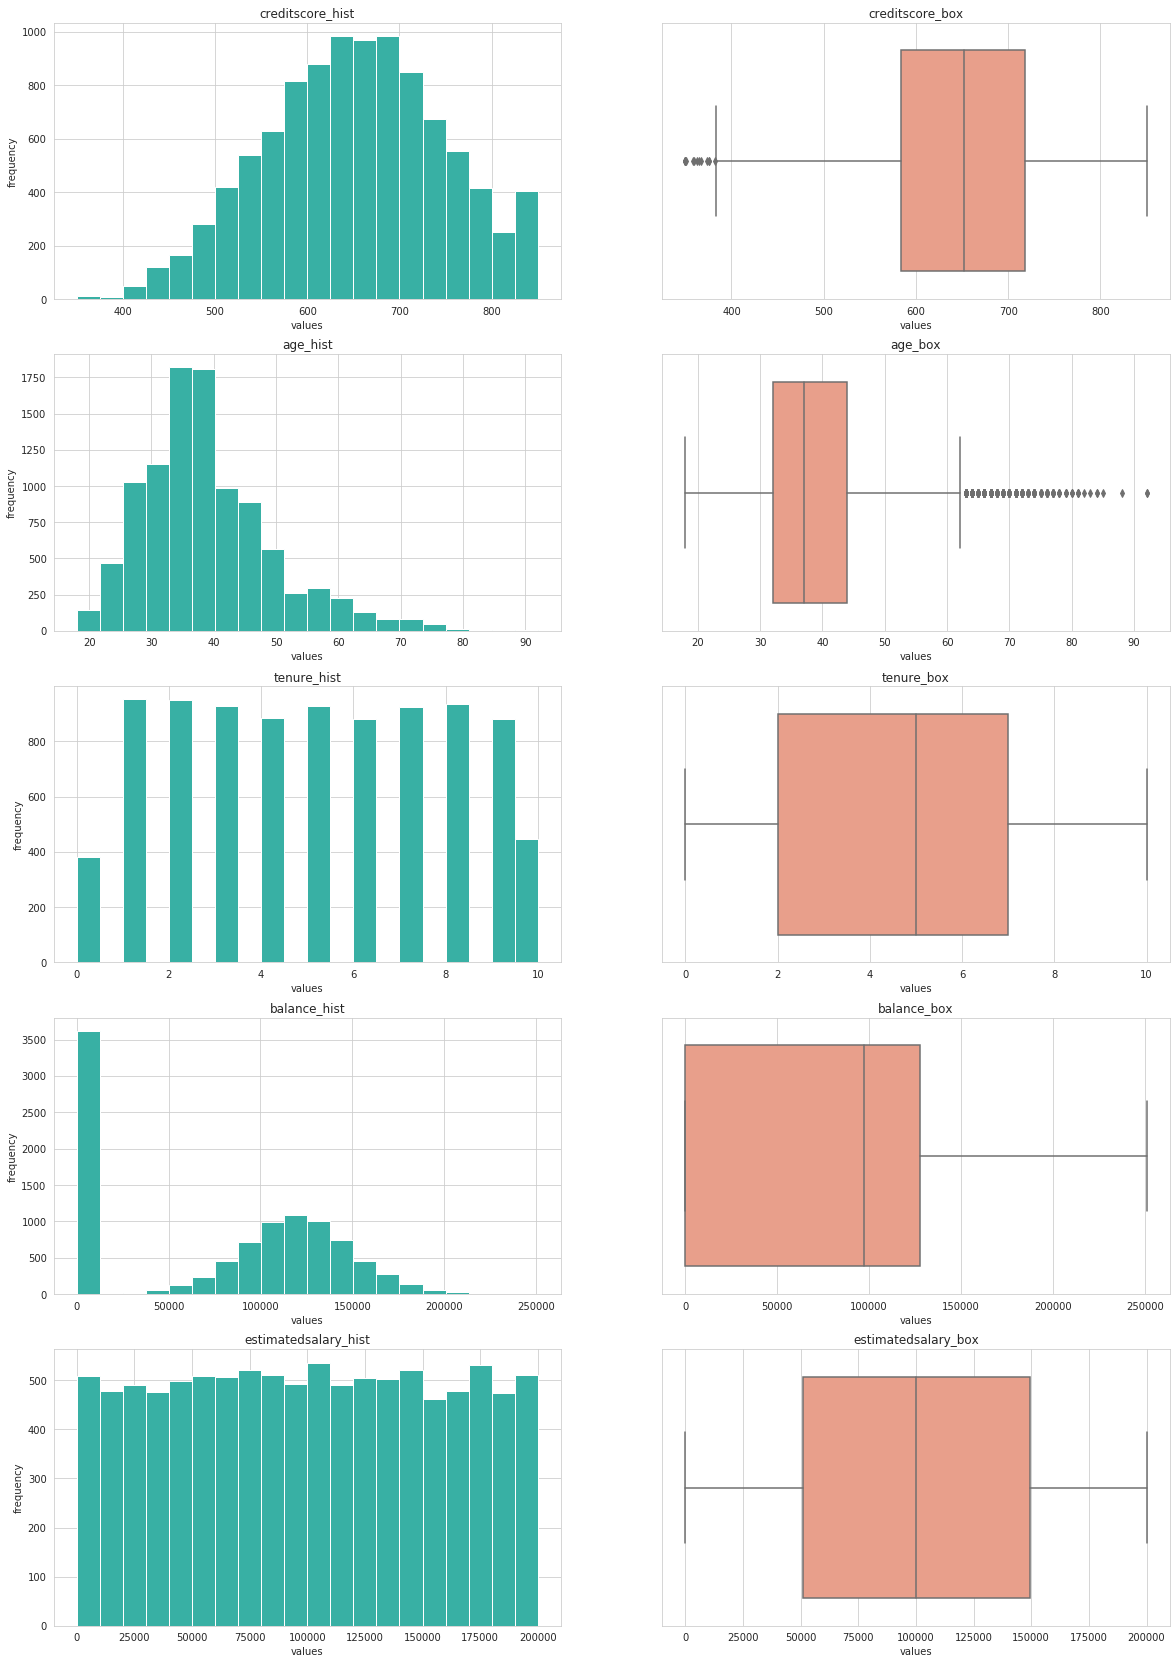

In [7]:
cont_data = [i for i in df.select_dtypes(include=['int','float']).columns if df[i].mean() > 2]
cont_data.remove('rownumber')
cont_data.remove('customerid')

plt.subplots(figsize=(20,60))
k = 0 
for i in cont_data:
    k+=1
    plt.subplot(10,2, k)
    plt.hist(df[i], bins=int(len(df[i])**.5 / 5), color='#38b0a4')
    plt.title(i + '_hist')
    plt.ylabel('frequency')
    plt.xlabel('values')
    k+=1
    plt.subplot(10,2, k)
    sns.boxplot(data=df, x=i, palette=['#f7967c'])
    plt.xlabel('values')
    plt.title(i + '_box')
plt.show()

Данные в столбцах `CreditSroce` и `Age` перекошены и в обоих столбцах присутствуют выбросы, в остальных столбцах нет аномальных значений, в столбце `Balance` можно отметить большое число записей с нулевыми значениями - <u>3612</u>, а для столбца `EstimatedSalary` характерно равномерное распределение. Визуально в столбце `CreditSroce` выбросов не много, исследуем их количество:

In [8]:
credit_outliers = list(plt.boxplot(df['creditscore'])["fliers"][0].get_data()[1]) 
plt.close()
print('Число записей в датасете с выбросами по столбцу creditscore:',len(df[df['creditscore'] <= max(credit_outliers)]))

Число записей в датасете с выбросами по столбцу creditscore: 15


Удалим их:

In [9]:
df = df[df['creditscore'] > max(credit_outliers)].reset_index(drop=True)
print('Размер датасета после очистки от выбросов:', len(df))

Размер датасета после очистки от выбросов: 9985


Исследуем число выбросов для столбца `Age`:

In [10]:
age_outliers = list(plt.boxplot(df['age'])["fliers"][0].get_data()[1]) 
plt.close()
print('Число записей в датасете с выбросами по столбцу age:', len(df[df['age'] >= min(age_outliers)]))

Число записей в датасете с выбросами по столбцу age: 359


Так как записей много, значения возраста реальны, а так же чтобы не терять полноту в данных, не будем их удалять. Значения выбросов компенсируются при стандартизации, а модели, основанные на решающих деревьях в меньшей степени чувствительны к масштабу признаков. Исследуем столбцы с категориальными данными:

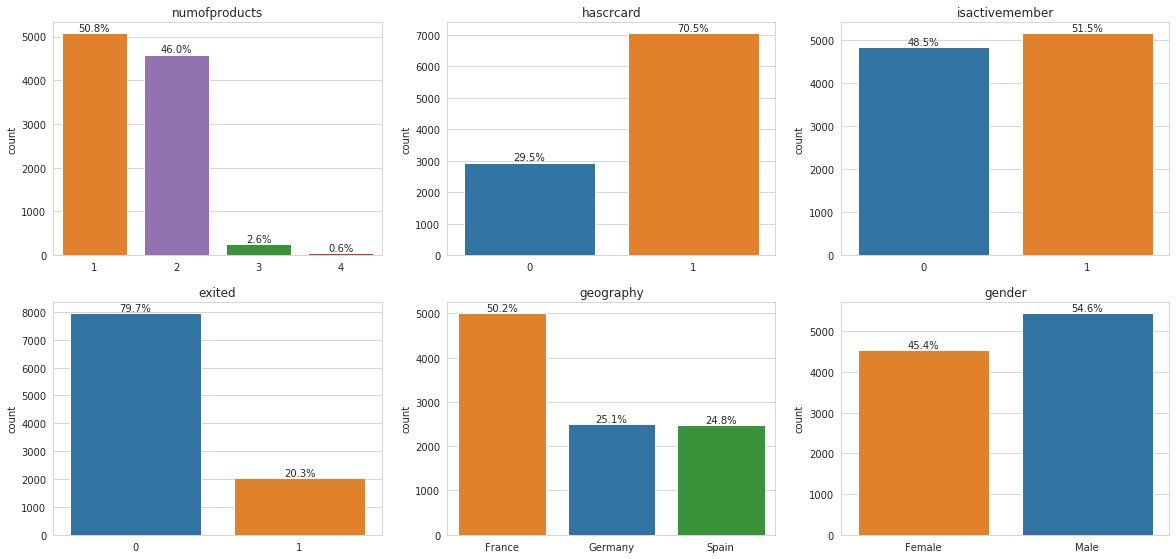

In [11]:
cols = [i for i in df.select_dtypes(include=['int','float']).columns if df[i].mean() <= 2]
cols.extend(df.select_dtypes(include='object').columns.tolist())
cols.remove('surname')

def vlc(row):
    vlc = df[row].value_counts().reset_index().rename(columns={'index':row, row:'count'})
    return vlc

plt.subplots(figsize=(20, 30))
for k, i in enumerate(cols):
    plt.subplot(6,3,k+1)
    data = vlc(i).sort_values(by=i)
    if data[i].tolist()[0] == 0:
        cl0, cl1 = 'C0', 'C1'
    elif i == 'numofproducts':
        cl0, cl1 = 'C1', 'C4'
    else: 
        cl1, cl0 = 'C0', 'C1'
    sns.barplot(data=data, x=i, y='count', palette=[cl0, cl1, 'C2', 'C3'])
    for index, value in enumerate(data['count']):
        plt.text(index, value, '{:.1%}'.format(value / data['count'].sum()), ha='center', va='bottom')
    plt.xlabel('')
    plt.title(i)
plt.show()

Как было отмечено выше, в целевом признаке `Exited` присутствует дисбаланс классов - значений 1-го класса всего 20%. Остальные категориальные признаки будем кодировать методом <u>Ordinal Encoding</u> для модели случайного леса и <u>One-Hot Encoding</u> для модели логистической регрессии.

Исследуем данные на наличие дубликатов:

In [12]:
print('Количество полных дубликатов в датафрейме:', df.drop(['rownumber'], axis=1).duplicated().sum())

Количество полных дубликатов в датафрейме: 0


Полных дубликатов нет, поищем дубликаты по фамилиям и столбцу `CustomerId`:

In [13]:
def totals(row):
    nuniq = df[row].nunique()
    dupl = df[row].duplicated().sum()
    print(f'В столбце {row} уникальных значений: {nuniq}, дублированных значений: {dupl}')
totals('surname')
totals('customerid')

В столбце surname уникальных значений: 2931, дублированных значений: 7054
В столбце customerid уникальных значений: 9985, дублированных значений: 0


Дублирующих фамилий в столбце подозрительно много, хотя, судя по столбцу `CustomerId`, все клиенты уникальные. Посмотрим число полных дубликатов по социальному статусу, будем использовать данные из столбцов `Surname`, `Geography`, `Gender`, `Age`:

In [14]:
social = df[df[['surname', 'geography','gender', 'age']].duplicated(keep=False)].sort_values(by=['surname'])
print('Число дубликатов по социальному статусу:', int(len(social) / 2))

Число дубликатов по социальному статусу: 236


In [15]:
social.head(10)

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
8914,8927,15709136,Adams,620,France,Male,28,8.0,0.00,2,1,1,199909.32,0
3457,3467,15631339,Adams,791,France,Male,28,4.0,0.00,1,1,0,174435.48,0
9768,9784,15680430,Ajuluchukwu,601,Germany,Female,49,4.0,96252.98,2,1,0,104263.82,0
8813,8826,15797081,Ajuluchukwu,611,Germany,Female,49,9.0,115488.52,2,1,1,138656.81,1
3834,3844,15677804,Aliyeva,783,Spain,Male,38,1.0,0.00,3,1,1,80178.54,1
1846,1853,15573741,Aliyeva,698,Spain,Male,38,10.0,95010.92,1,1,1,105227.86,0
6039,6049,15676433,Allan,707,France,Female,36,6.0,0.00,1,0,0,98810.78,0
3233,3243,15729908,Allan,411,France,Female,36,10.0,0.00,1,0,0,120694.35,0
4529,4539,15676835,Anayolisa,710,Spain,Male,33,1.0,0.00,2,1,0,168313.17,0
8828,8841,15646969,Anayolisa,776,Spain,Male,33,2.0,0.00,2,1,1,176921.00,0


В основном записи совпадают по столбцам фильтрации, количественные характеристики различаются. Дублирующие значения удалять не будем.

Исследуем пропуски в столбце `Tenure`:

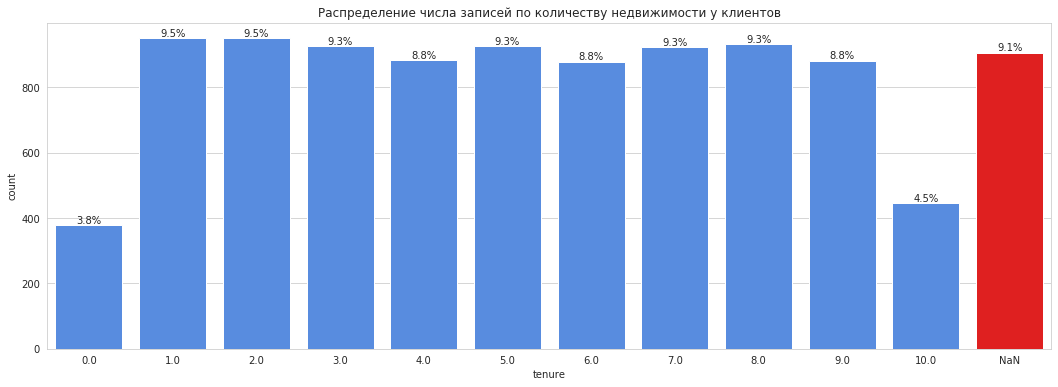

In [16]:
tenure = (df['tenure'].value_counts(dropna=False).sort_index()
          .reset_index().rename(columns={'index':'tenure', 'tenure':'count'}).round(2).fillna(value='NaN'))
clrs = ['red' if x == 'NaN' else '#4287f5' for x in tenure['tenure']]
sns.barplot(data=tenure, x ='tenure', y='count', palette=clrs)
for index, value in enumerate(tenure['count']):
    plt.text(index, value, '{:.1%}'.format(value/tenure['count'].sum()), ha='center', va='bottom')
plt.title('Распределение числа записей по количеству недвижимости у клиентов')
plt.show()

Поскольку модели не получится обучить по датасету с пропусками, их необходимо будет либо заполнить, либо удалить. Заполнить их будет сложнее, посольку клиентов придется сегментировать. 

Изучим соотношение распределения классов при фильтрации по пропускам и посмотрим, как изменится соотношение после потенциальной очистки:

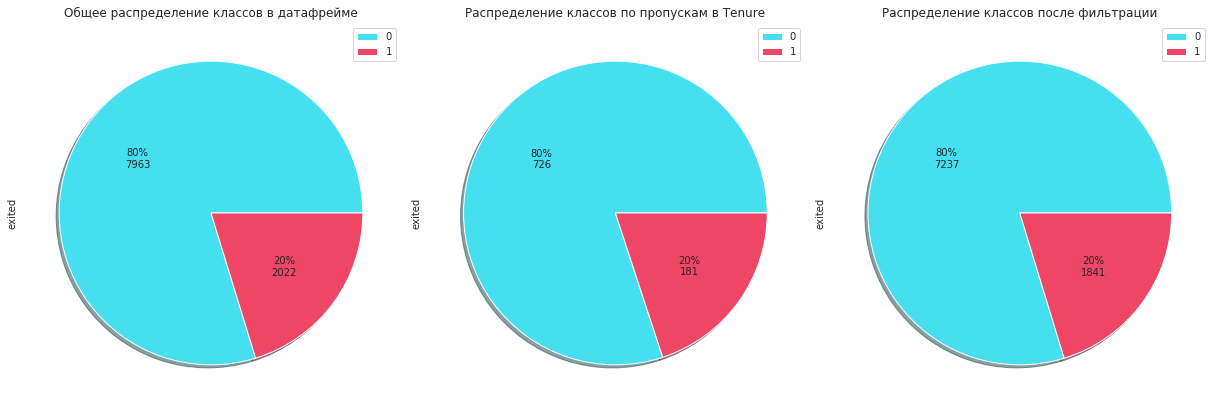

In [17]:
def pie_chart(data,title):
    colors = ['#46dff0', '#f04665']
    values = data['exited'].value_counts()
    values.plot(kind='pie',colors=colors, autopct=lambda x: '{:.0f}%\n{:.0f}'.format(x, x*values.sum()/100), 
                shadow=True, labels=None)
    plt.legend(values.index, loc='upper right') 
    plt.tight_layout()
    plt.title(title)
plt.subplots(figsize=(17, 14))
plt.subplot(1,3,1)
pie_chart(df,'Общее распределение классов в датафрейме')
plt.subplot(1,3,2)
pie_chart(df[df['tenure'].isna()],'Распределение классов по пропускам в Tenure')
plt.subplot(1,3,3)
pie_chart(df[~df['tenure'].isna()],'Распределение классов после фильтрации')
plt.show()

Целевой признак распеределен по пропускам точно так же, как и по всему датасету, очистка не повлияет на баланс классов, также при удалении пропусков размер датафрейма не сократится более чем на 10%.

In [18]:
before = len(df)
df = df.dropna(subset=['tenure']).reset_index(drop=True)
after = len(df)
print(f'Данных после очистки пропусков {after}, было удалено {before-after} записей, датафрейм уменьшился на {round(1-after/before,3)*100}%')

Данных после очистки пропусков 9078, было удалено 907 записей, датафрейм уменьшился на 9.1%


Исследуем признаки на мультиколлинеарность:

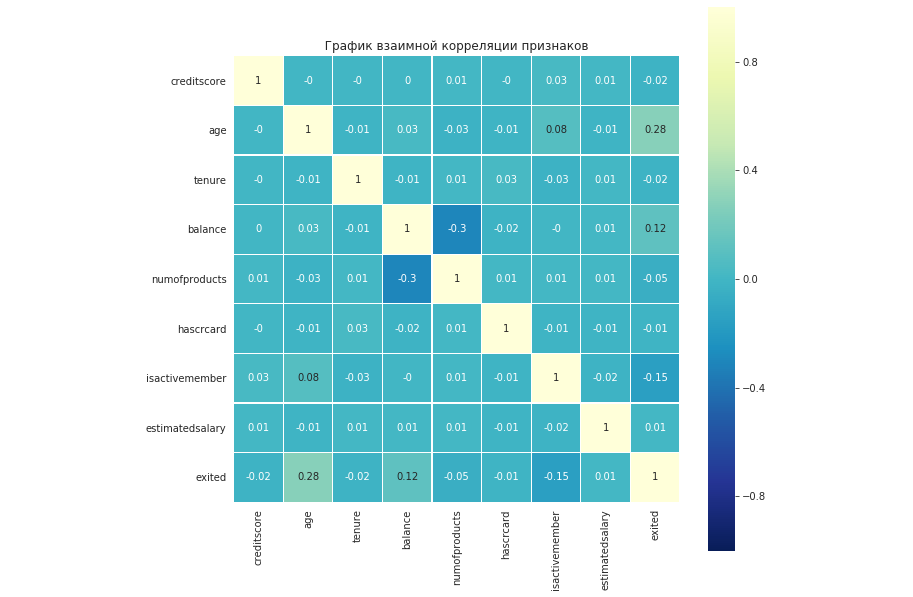

In [19]:
multicorr = df.select_dtypes(include=['int64','float64']).drop(['customerid', 'rownumber'], axis=1).corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(data=multicorr, annot=True, square=True, center=0, vmin=-1, vmax=1, cmap="YlGnBu_r", linewidths=.2)
plt.title(('График взаимной корреляции признаков').center(200))
plt.show()

Согласно полученным данным, в датасете нет сильно скоррелированных между собой признаков.

### Вывод

На этом этапе исследовали признаки, изучили их распределения и выполнили предобработку:
- Удалили выбросы и пропуски - датасет у меньшился на 9%
- Классы не сбалансированы, записей 1-го класса только 20%
- Мультиколлинеарности в данных нет

---
<a id='model_selection'></a>
## 3. Подготовка данных

Проведем кодирование данных для модели случайного леса:

In [20]:
df_encoded = df.drop(['surname', 'rownumber','customerid'], axis=1).copy()
encoder = OrdinalEncoder()
df_encoded = pd.DataFrame(data=encoder.fit_transform(df_encoded), columns=df_encoded.columns)

In [21]:
features = df_encoded.drop('exited', axis=1)
target = df_encoded['exited']

Разобьем данные на обучающую, валидационную и тестовую выборки:

In [22]:
features_train, features_val, target_train, target_val  = train_test_split(features, target, test_size=0.2, 
                                                                           stratify=target,
                                                                           random_state=42)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, 
                                                                            stratify=target_train,
                                                                            test_size=0.25, random_state=42)

Проведем стандартизацию данных:

In [23]:
columns = (features[features.columns].mean() > 2).to_frame(name='cols').query('cols == True').index.tolist()
scaler = StandardScaler()
features_train[columns] = scaler.fit_transform(features_train[columns])
features_val = features_val.copy()
features_val[columns] = scaler.transform(features_val[columns])
features_test = features_test.copy()
features_test[columns] = scaler.transform(features_test[columns])

In [24]:
display(features_train.head(3))
display(features_val.head(3))
display(features_test.head(3))

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
2831,0.025467,2.0,1.0,-0.856711,-0.334893,-0.961795,1.0,1.0,0.0,0.369891
6882,1.490979,2.0,0.0,-0.856711,-1.379667,1.692179,0.0,0.0,1.0,0.988675
5823,0.919325,0.0,0.0,-1.801633,-0.334893,1.106317,0.0,0.0,1.0,0.890189


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
7209,-1.398470,1.0,0.0,-0.573234,1.754656,1.275555,0.0,1.0,1.0,0.489754
1447,1.137593,1.0,0.0,0.938641,1.406397,-0.465986,0.0,1.0,0.0,0.315303
5754,1.449404,2.0,1.0,-0.195265,1.058139,-0.961795,1.0,1.0,1.0,0.871866


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
7544,-1.356895,0.0,0.0,-0.006281,0.361623,1.474292,0.0,0.0,0.0,0.091228
4957,-0.026501,1.0,1.0,0.466180,1.406397,0.206306,1.0,1.0,1.0,-0.131703
2274,0.680270,0.0,0.0,-0.951203,1.754656,-0.541030,0.0,1.0,1.0,1.441026


Изучим размеры тренировочной, валидационной и тестовой выборок после разделения:

In [25]:
def size(data):
    print('Размер датасета после разделения на выборки {:.0%}'.format(len(data)/len(features)))

In [26]:
size(features_train)

Размер датасета после разделения на выборки 60%


In [27]:
size(features_val)

Размер датасета после разделения на выборки 20%


In [28]:
size(features_test)

Размер датасета после разделения на выборки 20%


Распределение классов после разделения:

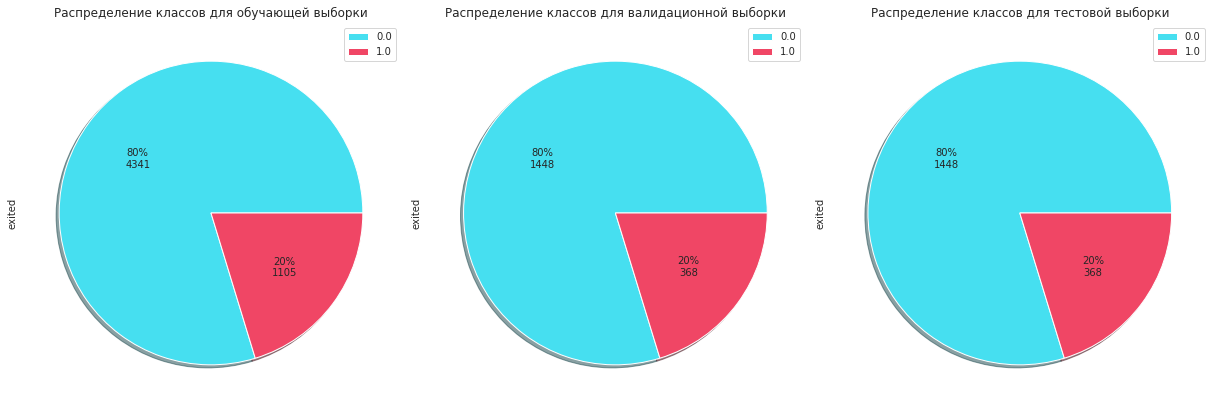

In [29]:
plt.subplots(figsize=(17, 14))
plt.subplot(1,3,1)
pie_chart(target_train.to_frame('exited'),'Распределение классов для обучающей выборки')
plt.subplot(1,3,2)
pie_chart(target_val.to_frame('exited'),'Распределение классов для валидационной выборки')
plt.subplot(1,3,3)
pie_chart(target_test.to_frame('exited'),'Распределение классов для тестовой выборки')
plt.show()

Дополнительно убедимся, что записи в тестовой и валидационной выборке после разделения никак не могут пересекаться:

In [30]:
print('Число уникальных индексов в объединенной тестовой и валидационной выборке:',
      len(set(target_val.index).union(set(target_test.index))))

Число уникальных индексов в объединенной тестовой и валидационной выборке: 3632


Отдельно подготовим данные для модели логистической регрессии. Поскольку модели должны обучаться на одних и тех же данных, используем уже разбитые выборки и перекодируем столбцы `geography` и `gender`.

In [31]:
features_train_log = features_train.copy()
features_val_log = features_val.copy()
features_test_log = features_test.copy()
log_sample = [features_train_log, features_val_log, features_test_log]

for i in log_sample:
    i[['geography','gender']] = df[['geography','gender']]

features_train_log = pd.get_dummies(features_train_log, drop_first=True)
features_val_log = pd.get_dummies(features_val_log, drop_first=True)
features_test_log = pd.get_dummies(features_test_log, drop_first=True)

### Вывод

На этом этапе подготовили данные для случайного леса и логистической регрессии, было проведено:
- кодирование категориальных признаков
- стандартизация данных
- разделение данных по принципу 3:1:1 на обучающую, валидационную и тестовую выборки. Баланс классов сохранился после раздления от изначального.

--- 
<a id='dis'></a>
## 4. Исследование моделей без учета дисбаланса классов

Построим модель случайного леса:

In [32]:
model = RandomForestClassifier(n_estimators=10, max_depth=17, random_state=42)
model.fit(features_train,target_train)
preds_val = model.predict(features_val)

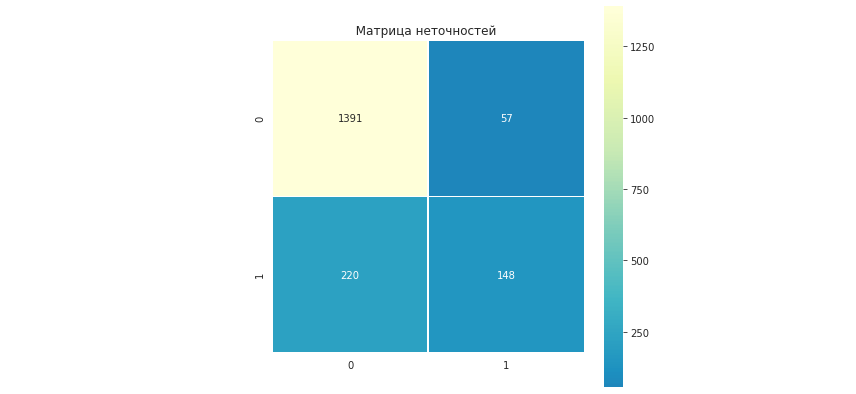

In [33]:
def conf_matr(target, preds):
    plt.figure(figsize=(7,7))
    sns.heatmap(data=confusion_matrix(target, preds), square=True, annot=True, fmt="d", cmap="YlGnBu_r", 
                linewidths=.5, center=confusion_matrix(target, preds)[1].sum())
    plt.title(('Матрица неточностей').center(200))
    plt.show()
conf_matr(target_val, preds_val)

In [34]:
def report(target, preds):
    print(classification_report(target, preds))
    print('ROC_AUC score: {:.2f}'.format(roc_auc_score(target, preds)))
report(target_val, preds_val)

              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      1448
         1.0       0.72      0.40      0.52       368

    accuracy                           0.85      1816
   macro avg       0.79      0.68      0.71      1816
weighted avg       0.83      0.85      0.83      1816

ROC_AUC score: 0.68


У обученной модели случайного леса не очень высокая метрика полноты, она не очень хорошо различает первый класс: больше половины всех записей класса 1 она классифицировала как 0. При этом у неё неплохая точность - она намного реже ошибочно классифицирует нулевые значения - всего в 28% случаев. 
Метрика f1_score = 0.52, а мощность модели 0.68, что говорит о том, что все же какой-то предсказательной силой модель обладает.

Проверка модели на адекватность:

In [35]:
def model_test(target):
    zero_val = pd.Series(0 for i in range(len(target)))
    print("ROC_AUC: {:.2f}, Accuracy: {:.2f}".format(roc_auc_score(target, zero_val), 
                                                 accuracy_score(target, zero_val)))

In [36]:
model_test(target_val)

ROC_AUC: 0.50, Accuracy: 0.80


Accuracy константной модели ниже на 5%

Построим модель логистической регрессии без учета дисбаланса классов:

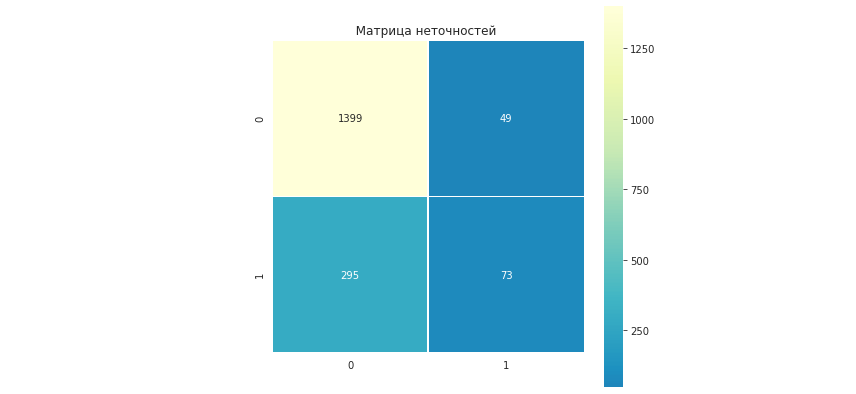


              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89      1448
         1.0       0.60      0.20      0.30       368

    accuracy                           0.81      1816
   macro avg       0.71      0.58      0.59      1816
weighted avg       0.78      0.81      0.77      1816

ROC_AUC score: 0.58


In [37]:
model_log = LogisticRegression(solver='liblinear', random_state=42)
model_log.fit(features_train_log, target_train)
preds_val_log = model_log.predict(features_val_log)

def all_metrics(target, predictions):
    conf_matr(target, predictions)
    print()
    report(target, predictions)
    
all_metrics(target_val, preds_val_log)

Модель логистической регерссии очень плохо угадывает первый класс - всего 20% правильных ответов или 73 записи из 368, метрика мощности ROC_AUC близка к случайной модели, f1_score так же очень низкий - всего 0.30. Accuracy этой модели выше всего на 1% случайной.

### Вывод

На этом этапе обучали модели без учета дисбаланса классов.

Для случайного леса получены следующие результаты метрик:
- recall: 0.45
- precision: 0.69
- f1_score: 0.55
- roc_auc: 0.70

Для логистической регрессии получены следующие результаты метрик:
- recall: 0.20
- precision: 0.60
- f1_score: 0.30
- roc_auc: 0.58

Очевидно, случайный лес намного лучше обучился на несбалансированных данных. Предсказательная сила логистической регрессии близка к уровню случайной модели.

---
<a id='balanced'></a>
## 5. Борьба с дисбалансом


### 5.1 Взвешивание классов и поиск оптимального порога

Для модели случайного леса используем параметр class_weight='balanced', чтобы взвесить классы, а при помощи GridSearchCV найдем оптимальные параметры:

In [38]:
%%time
model = RandomForestClassifier(random_state=42, class_weight='balanced')
parameters_grid = {
    'n_estimators':[50, 100, 150],
    'max_depth':[*(range(6,12))]
}
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=5)
grid_cv.fit(pd.concat([features_train, features_val, features_test]), 
            pd.concat([target_train, target_val, target_test]))
print(grid_cv.best_params_, grid_cv.best_score_)

{'max_depth': 10, 'n_estimators': 150} 0.6129982721891218
CPU times: user 1min 16s, sys: 138 ms, total: 1min 16s
Wall time: 1min 17s


In [39]:
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=150, max_depth=10)
model.fit(features_train, target_train)
preds_val = model.predict(features_val)

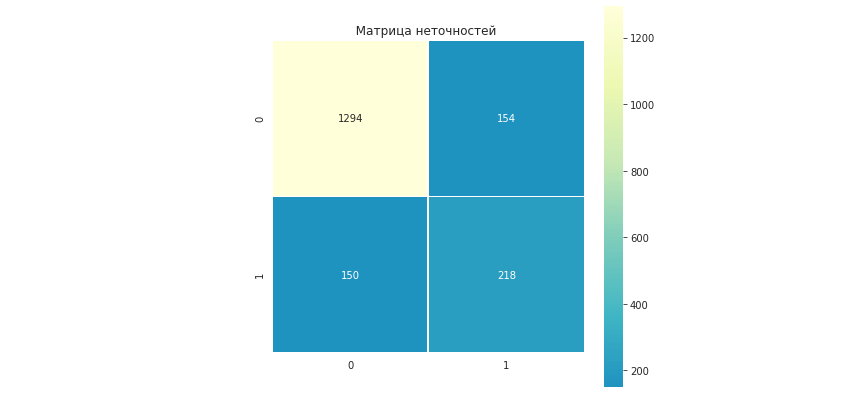


              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      1448
         1.0       0.59      0.59      0.59       368

    accuracy                           0.83      1816
   macro avg       0.74      0.74      0.74      1816
weighted avg       0.83      0.83      0.83      1816

ROC_AUC score: 0.74


In [40]:
all_metrics(target_val, preds_val)

Удалось достичь более высокого результата для метрики f1_score - 0.59. 59% значений первого класса модель классифицирует верно, точность на том же уровне, что и полнота. Мощность модели 0.74. 

Попробуем подобрать пороги классификации, чтобы улучшить метрику f1-score - будем подставлять разные значения порога от 0.25 до 0.7 с шагом 0.01, измененную классификацию будем подставлявть в формулы расчета f1-меры и мощности модели:

In [41]:
def test_threshold(features, target, model_name):
    start=time.time()
    values = []
    for k in np.arange(0.25, 0.7, 0.01):
        new_class = [1 if i > k else 0 for i in model_name.predict_proba(features)[:,1]]
        f1=f1_score(target, new_class)
        roc=roc_auc_score(target, new_class)
        values.append([k,f1,roc])
    iterations = pd.DataFrame(data=values, columns=['threshold', 'f1_score', 'roc_auc_score'])
    display(iterations[iterations['f1_score']==iterations['f1_score'].max()]
            .reset_index(drop=True).stack()[0].to_frame(name='metrics'))
    end=time.time()
    timing = round(end - start, 2)
    print(f'Поиск оптимального порога для метрики f1_score занял {timing} секунд(ы)')

In [42]:
test_threshold(features_val, target_val, model)

,metrics
threshold,0.510000
f1_score,0.595862
roc_auc_score,0.744790


Поиск оптимального порога для метрики f1_score занял 3.52 секунд(ы)


In [43]:
def thresh_classifier(model_name, features, thresh):
     return [1 if i > thresh else 0 for i in model_name.predict_proba(features)[:,1]]
report(target_val, thresh_classifier(model, features_val, .51))

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      1448
         1.0       0.61      0.59      0.60       368

    accuracy                           0.84      1816
   macro avg       0.75      0.74      0.75      1816
weighted avg       0.84      0.84      0.84      1816

ROC_AUC score: 0.74


Метрика F1-score увеличилась, а также выросола точность на 0,02.

---

### 5.2 Уменьшение выборки

In [44]:
#Функция уменьшает размер выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train_log, target_train, 0.3)

#Распределение классов после уменьшения
def perc(series):
    return (series.value_counts().to_frame(name='exited')
            .assign(ratio = lambda x: (x['exited'] / x['exited'].sum()).map(lambda x: '{:.1%}'.format(x))))
perc(target_downsampled)

,exited,ratio
0.0,1302,54.1%
1.0,1105,45.9%


In [45]:
model_downsampled = LogisticRegression(solver='liblinear', random_state=42)
model_downsampled.fit(features_downsampled, target_downsampled)
preds_val_downsampled = model_downsampled.predict(features_val_log)
report(target_val, preds_val_downsampled)

              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82      1448
         1.0       0.40      0.59      0.47       368

    accuracy                           0.73      1816
   macro avg       0.64      0.68      0.65      1816
weighted avg       0.78      0.73      0.75      1816

ROC_AUC score: 0.68


После балансирования классов методом downsampling, у модели логистической регрессии заметно выросла полнота - до 0.59 с 0.20 и f1-score до 0.47 с 0.30. Так или иначе, модель показала результат хуже случайного леса, поэтому финальное тестирование логистической регрессии проводить не будем.

### Вывод

На этом этапе обучили модели случайного леса и логистической регрессии с учетом дисбаланса классов. Для случайного леса взвесили классы и подобрали порог классификации:
- recall: 0.59
- precision: 0.61
- f1_score: 0.60
- roc_auc: 0.74

Для логистической регрессии провели балансирование классов методом downsampling и получили следующие метрики:
- recall: 0.59
- precision: 0.40
- f1_score: 0.47
- roc_auc: 0.68

Регрессия показала себя хуже по всем метрикам, поэтому финальное тестирование будем проводить для модели случайного леса.

---
<a id='testing'></a>
## 6. Тестирование модели

Соединим тестовую и валидационную выборки, чтобы у модели было больше данных для обучения:

In [46]:
features_train['exited'] = target_train
features_val['exited'] = target_val
features_target_train_val = features_train.merge(features_val, how='outer', on=features_train.columns.tolist())
features_train_val = features_target_train_val.drop(['exited'], axis=1)
target_train_val = features_target_train_val['exited']

Проверим размер датасета и распределение классов после склейки:

In [47]:
features_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7262 entries, 0 to 7261
Data columns (total 10 columns):
creditscore        7262 non-null float64
geography          7262 non-null float64
gender             7262 non-null float64
age                7262 non-null float64
tenure             7262 non-null float64
balance            7262 non-null float64
numofproducts      7262 non-null float64
hascrcard          7262 non-null float64
isactivemember     7262 non-null float64
estimatedsalary    7262 non-null float64
dtypes: float64(10)
memory usage: 624.1 KB


In [48]:
perc(target_train_val)

,exited,ratio
0.0,5789,79.7%
1.0,1473,20.3%


Обучим модель на новых данных:

In [49]:
model.fit(features_train_val, target_train_val)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

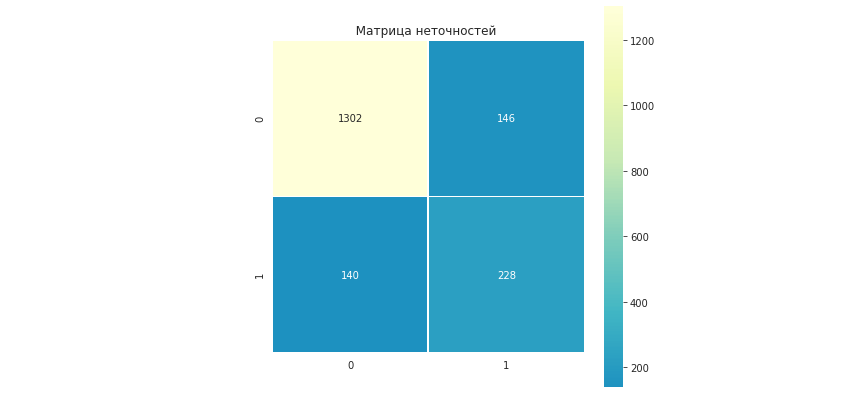


              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90      1448
         1.0       0.61      0.62      0.61       368

    accuracy                           0.84      1816
   macro avg       0.76      0.76      0.76      1816
weighted avg       0.84      0.84      0.84      1816

ROC_AUC score: 0.76


In [50]:
test_preds = model.predict(features_test)
all_metrics(target_test, test_preds)

Обучение на большем количестве данных дало результаты. Увеличилась f1 на 0.02 (без учета подбора порога), ROC_AUC и точность также выросли на 0.02, полнота на 0.03.

Подберем оптимальный порог классификации:

In [51]:
test_threshold(features_test, target_test, model)

,metrics
threshold,0.480000
f1_score,0.617608
roc_auc_score,0.764735


Поиск оптимального порога для метрики f1_score занял 3.07 секунд(ы)


In [52]:
report(target_test, thresh_classifier(model, features_test, .48))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      1448
         1.0       0.60      0.64      0.62       368

    accuracy                           0.84      1816
   macro avg       0.75      0.76      0.76      1816
weighted avg       0.84      0.84      0.84      1816

ROC_AUC score: 0.76


Путём изменения порога снизилась точность на 0.01, метрика f1 выросла на 0.01, а полнота на 0.02.

### Вывод

На этом этапе протестировали модель случайного леса на тестовой выборке, применили порог классификации и получили следующие метрики:
- recall: 0.64
- precision: 0.60
- f1_score: 0.62
- roc_auc: 0.76

--- 
<a id='out'></a>
## 7. Общий вывод

В результате проделанной работы был исследован датасет с записями о клиентах банка, данные были преодобработаны - удалены дубликаты и пропуски, и подготовлены - убраны лишние столбцы, категориальные данные кодированы, а количественные стандартизированы. Были построены модели логистической регрессии и случайного леса (с учетом и без учета дисбаланса классов), предсказывающие вероятность оттока. Для балансирования классов были использованы методы уменьшения выборки, взвешивания классов и поиск оптимального порога. 
Модель логистической регресии на валидационной выборке показала себя значительно хуже случайного леса - все метрики ниже на 0.05-0.2 значений. 

Случайный лес с корректировкой порога на тестовой выборке показал следующие метрики:
- recall: 0.64
- precision: 0.60
- f1_score: 0.62
- roc_auc: 0.76